In [2]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

BDC is using numpy


In [3]:
#define some basic functions here, like xcorr and etc

@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


<h1 style="font-size:30pt">Setup</h1>

Start with basic hard-coded stuff (to make config later)

In [4]:

#spectrum interval (aka period) (4096 point FFT, 250M sampling rate)
T_SPECTRA = 4096/250e6

#start and end times
start_file_time = 1721800002
t_start = start_file_time  #for easy correlation purposes
t_end = t_start + 1800

#set integration times for coarse and visibilities (spectra per chunk)
c_acclen = 10**6 
acclen = 30* 10**3 
print(c_acclen, acclen)

#time taken for one full chunk 
T_ACCLEN_C = c_acclen* T_SPECTRA
T_ACCLEN_V = acclen* T_SPECTRA
#how many total chunks for the time interval we care about
nchunks_c = int((t_end-t_start)/T_ACCLEN_C)
nchunks_v = int((t_end-t_start)/T_ACCLEN_V)


#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print(files_a1)
print(files_a2)
print("Uncorrected Starting Indices:", idx1, idx2)
print("Initial Offset:", idx1-idx2)


#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart 

1000000 30000
['/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800002.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800047.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800091.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800135.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800180.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800224.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800269.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800313.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800357.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800402.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800446.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800490.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800535.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/

Here is the List of passes:

In [5]:
passes = [[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]]]

for i in range(len(passes)):
    passes[i][0] = (np.array(passes[i][0]) * 5).tolist()

print(passes)

for i in range(len(passes)):
    print(f"Pass {i} in seconds offset:", passes[i][0])

time_offsets = [ p[0][0]+40 for p in passes]
print(time_offsets)


[[[715, 1110], [3]], [[4950, 5270], [1]], [[7000, 7145], [3]], [[8615, 8970], [0]], [[10975, 11440], [1]], [[14630, 15110], [0]], [[17005, 17530], [1]]]
Pass 0 in seconds offset: [715, 1110]
Pass 1 in seconds offset: [4950, 5270]
Pass 2 in seconds offset: [7000, 7145]
Pass 3 in seconds offset: [8615, 8970]
Pass 4 in seconds offset: [10975, 11440]
Pass 5 in seconds offset: [14630, 15110]
Pass 6 in seconds offset: [17005, 17530]
[755, 4990, 7040, 8655, 11015, 14670, 17045]


In [9]:
pulse_idx = 0

t_start += time_offsets[pulse_idx]
t_end += time_offsets[pulse_idx]

files_a1, idx1 = butils.get_init_info(t_start_pulse, t_end_pulse, a1_path)
files_a2, idx2 = butils.get_init_info(t_start_pulse, t_end_pulse, a2_path)

idx_correction=109993-100000
if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)

ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1, acclen, nchunks=nchunks_v, chanstart=chanstart, chanend=chanend, type='float')
ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2, acclen, nchunks=nchunks_v, chanstart=chanstart, chanend=chanend, type='float')


ACCLEN RECEIVED IS 30000
took 0.184 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721817046.raw
START SPECNUM IS 2030110242 obj start at 2030039214
ACCLEN RECEIVED IS 30000
took 0.171 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721817018.raw
START SPECNUM IS 2086330477 obj start at 2084560457


<h1 style="font-size:30pt">Visibility Stuff</h1>

Now, once we have the predicted phase and have the index offset set up, we can find the observed phases. Recall that for now, this is only done for ONE satellite pass. We want to get to at least five passes, so in the streamlined code this will be done recursively.

In [11]:
#getting visibility

m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks_v,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
        
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*acclen,
                m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)


CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
took 1.411 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721817062.raw
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  

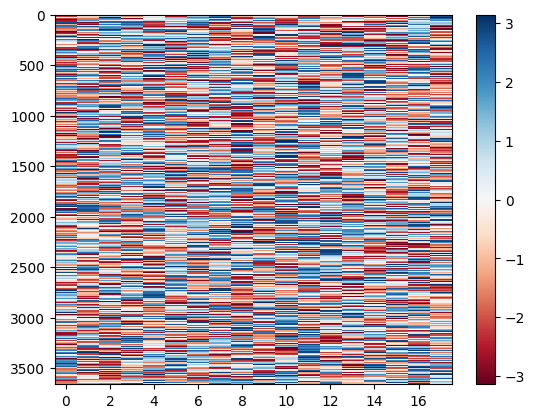

In [12]:
#plot visibility phase for the whole time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

395


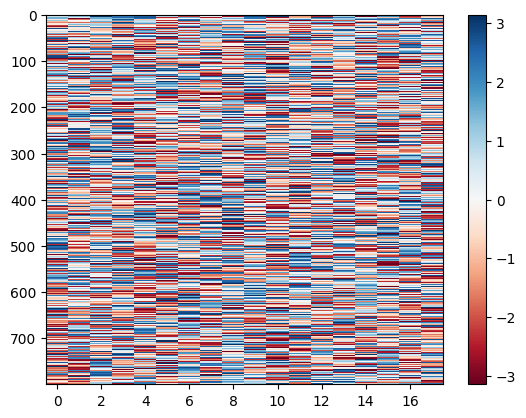

In [14]:
#for part of the time
isolated_time = 800

vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:isolated_time,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()


print((222-143) * 5)

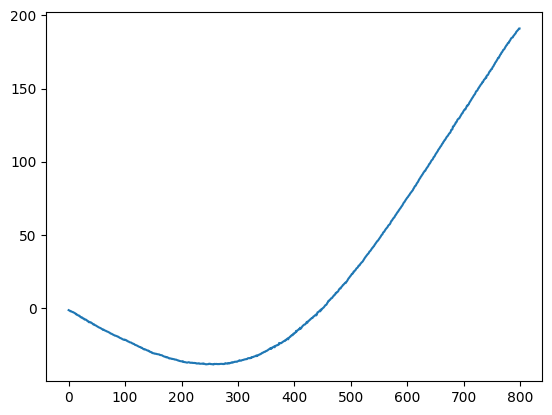

In [ ]:
#plot visibility total

plt.plot(np.unwrap(vis_phase[0:isolated_time,3]))